# K Nearest Neighbors

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
import time
import pickle
from collections import defaultdict 

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Nos modules
import modules.knn as knn
import modules.scoring as sc
import modules.feature_selection as fs
import modules.params_tuning as pt

## 1. Importation des données

In [2]:
data = pd.read_csv("data.csv")

In [3]:
print(data.shape)
data.head()

(1000, 32)


,filename,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,spectral_contrast,spectral_flatness,tonnetz,estimated_tempo,genre/label
0,country.00094,0.366838,0.206715,1474.849928,1745.839794,3108.264538,0.062993,-104.34503,136.39078,-20.945368,...,2.197093,-7.109390,1.849674,1.675598,-1.492039,23.567712,0.001825,0.026578,112.347147,country
1,country.00025,0.347253,0.079920,1565.431223,2016.069774,3188.930717,0.057303,-200.55273,119.67490,-3.610737,...,-11.293138,-8.870809,-8.073557,-3.161044,0.330751,19.845071,0.008667,0.018447,143.554688,country
2,country.00076,0.297332,0.128385,1321.679067,1409.586676,2590.392670,0.066525,-183.93301,159.80644,-23.158834,...,-3.583324,-9.062474,-3.159365,-4.068544,-7.052489,23.526738,0.001220,-0.013900,143.554688,country
3,country.00030,0.221390,0.079631,1240.515214,1996.754074,2412.635411,0.042844,-277.08127,128.25803,42.433240,...,1.391878,3.080010,2.513260,-1.051766,-2.753359,22.093318,0.002381,-0.009946,161.499023,country
4,country.00089,0.322114,0.104638,1321.678546,1667.211777,2583.926042,0.052503,-205.12328,140.99438,-8.959963,...,3.140506,-4.527332,2.654261,-3.122376,-10.710899,24.189410,0.001850,0.002900,143.554688,country


In [4]:
# On supprime la premiere colonne
data = data.drop(['filename'],axis=1)

# On change les noms des genres par des entiers (de 0 a 9) car notre random forest ne prend en compte que des entiers comme labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
labels = encoder.fit_transform(genre_list)
data.iloc[:, -1] = labels

In [5]:
# On standardise le dataset
scaler = StandardScaler()
data_normalized = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

## 2. Apprentissage du modèle de base
Notre classifieur des k plus proches voisins a trois paramètres :
* `n_neighbors` -- le nombre de voisins d'un point
* `metric` -- la distance à appliquer
* `p` -- l'ordre de la distance de Minkowski

In [6]:
# On separe le dataset en train set et test set (80%/20%)
data_train, data_test, label_train, label_test = train_test_split(data_normalized, labels, test_size=0.2)
n_samples, n_features = data_train.shape

print("data_train {0} | label_train {1}".format(data_train.shape, label_train.shape))
print("data_test  {0} | label_test  {1}".format(data_test.shape, label_test.shape))

data_train (800, 30) | label_train (800,)
data_test  (200, 30) | label_test  (200,)


On entraîne le modèle de base dont les paramètres par défaut sont :

        n_neighbors = 1
        metric = minkowski
        p = 2

In [7]:
# Instantiation du modèle de base
base_model = knn.OurKNeighborsClassifier()

# Entrainement du modèle de base
base_model.fit(data_train, label_train)

# Test de validation
start = time.time()
base_model_predictions = base_model.predict(data_test)
end = time.time()
print("Execution time for predictions: %f sec"%(float(end) - float(start)))

base_model.score_ = sc.accuracy_score(base_model_predictions, label_test) * 100

Execution time for predictions: 6.588996 sec


In [8]:
# Comparaison avec sklearn
sklearn_rf = KNeighborsClassifier(n_neighbors=base_model.n_neighbors)
sklearn_rf.fit(data_train, label_train)
sklearn_predictions = sklearn_rf.predict(data_test)

In [9]:
print("Our k neighbors classifier score: {} %".format(base_model.score_))
print("Sklearn score: {} %".format(sc.accuracy_score(sklearn_predictions, label_test) * 100))

Our k neighbors classifier score: 67.0 %
Sklearn score: 67.0 %


## 3. Feature selection
Un moyen d'améliorer notre modèle est de sélectionner les caractéristiques les plus discriminantes. 

* https://towardsdatascience.com/de-coding-random-forests-82d4dcbb91a1
* https://hub.packtpub.com/4-ways-implement-feature-selection-python-machine-learning/

In [10]:
print("Shape of the dataset ", data_train.shape)
print("Size of the dataset before feature selection: %.2f MB"%(data_train.nbytes/1e6))
features_name = data.drop(['genre/label'], axis=1).columns

Shape of the dataset  (800, 30)
Size of the dataset before feature selection: 0.19 MB


In [11]:
# 7-8 MIN
start = time.time()
features, importances = fs.findFeatureImportance(base_model, data_train, label_train)
end = time.time()
print("Execution time to find the most important feature: %f sec"%(float(end) - float(start)))

Execution time to find the most important feature: 471.087994 sec


In [12]:
feature_importances = pd.DataFrame(zip(features_name, importances), columns = ['feature','importance']).sort_values('importance', ascending=False)

feature_importances[:10]

,feature,importance
28,tonnetz,0.01250
29,estimated_tempo,0.01125
27,spectral_flatness,0.01000
9,mfcc4,0.01000
1,rms,0.00625
25,mfcc20,0.00625
24,mfcc19,0.00625
8,mfcc3,0.00625
21,mfcc16,0.00500
10,mfcc5,0.00500


On sélectionne les caractéristiques dont l'importance est supérieure à 0.001

In [13]:
# On sélectionne les caractéristiques dont l'importance est supérieure à 0.001
indexes = feature_importances[feature_importances['importance'] > 0.001].index

# On transforme le dataset d'entrainement
fs_data_train = fs.transform(data_train, indexes)
fs_data_test = fs.transform(data_test, indexes)

print("Shape of the dataset ", fs_data_train.shape)
print("Size of the dataset after feature selection: %.2f MB"%(fs_data_train.nbytes/1e6))

Shape of the dataset  (800, 26)
Size of the dataset after feature selection: 0.17 MB


In [14]:
# Entrainement du modèle de base avec feature selection
fs_base_model = knn.OurKNeighborsClassifier()
fs_base_model.fit(fs_data_train, label_train)

# Test de validation
start = time.time()
fs_base_model_predictions = fs_base_model.predict(fs_data_test)
end = time.time()
print("Execution time for predictions with feature selection: %f sec"%(float(end) - float(start)))

fs_base_model.score_ = sc.accuracy_score(fs_base_model_predictions, label_test) * 100

Execution time for predictions with feature selection: 3.257288 sec


In [15]:
# Comparaison avec sklearn
sklearn_rf.fit(fs_data_train, label_train)
fs_sklearn_predictions = sklearn_rf.predict(fs_data_test)

In [16]:
# Score
print("Our k neighbors classifier score after feature selection: {} %".format(fs_base_model.score_))
print("Sklearn score : {} %".format(sc.accuracy_score(fs_sklearn_predictions, label_test) * 100))   

Our k neighbors classifier score after feature selection: 68.0 %
Sklearn score : 68.0 %


## 4. Réglage des hyperparamètres

Recherche exhaustive sur `n_neighbors` et ordre `p` de la distance de Minkowski.
* p = 1 correspond à la distance de Manhattan
* p = 2 correspond à la distance euclidienne
* p = $\infty$ correspond à la distance de Chebyshev

Nous avons choisi de se concentrer uniquement sur la distance de Minkowski, étant celle la plus courante.

In [17]:
# n_neighbors
n_neighbors = list(range(1,40,2))

# p
p = [1, 2, "+infty"]

param_grid = {
    'n_neighbors': n_neighbors,
    'p': p,
}

### Sans feature selection

In [18]:
# 10 MIN
# Instanciation du grid search model
grid_search_knn = pt.GridSearchCV(estimator = knn.OurKNeighborsClassifier, 
                                  param_distributions = param_grid,
                                  cv = 5)

# Entrainement du modele
start = time.time()
grid_search_knn.fit(data_train, label_train)
end = time.time()
print("Execution time for k nearest classifier training: %f sec"%(float(end) - float(start)))

Execution time for k nearest classifier training: 424.937096 sec


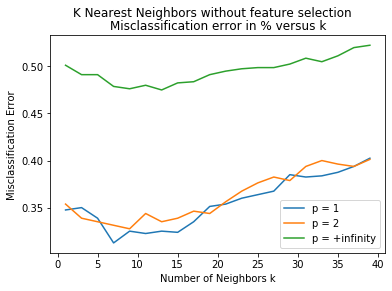

In [19]:
cv_results = grid_search_knn.cv_results_

# Calcul des erreurs de classification selon l'ordre p de la distance de minkowski
mse = defaultdict(list)
for i, estimator in enumerate(cv_results["estimators"]):
    p_value = estimator.get_params()["p"]
    mse[p_value].append(1 - cv_results["scores"][i])

# Affichage de l'erreur de classification en fonction de la valeur de k 
# et de l'ordre p de la distance de minkowski
plt.plot(n_neighbors, mse[1], label="p = 1")
plt.plot(n_neighbors, mse[2], label="p = 2")
plt.plot(n_neighbors, mse["+infty"], label="p = +infinity")
plt.suptitle("K Nearest Neighbors without feature selection")
plt.title("Misclassification error in % versus k")
plt.xlabel("Number of Neighbors k")
plt.ylabel("Misclassification Error")
plt.legend()
plt.savefig("Models/knn_misclassification_error.png")
plt.show()
plt.close()

On observe l'importance de la distance utilisée sur la performance du modèle. Les erreurs résultantes de la distance de Chebyshev sont deux fois plus importantes qu'avec la distance de Manhattan ou euclidienne. Quant à ces deux distances, les erreurs sont sensiblement les mêmes. Toutefois un minimum existe et est atteint lorsque :
        
        p = 1
        k = 7
        
L'utilisation d'une autre distance peut potentiellement améliorer la précision du modèle mais nous n'en étudierons pas dans ce notebook.

In [20]:
print("The best hyperparameters from Grid Search are:\n", grid_search_knn.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:\n %.2f"%(grid_search_knn.best_score_))

The best hyperparameters from Grid Search are:
 {'n_neighbors': 7, 'metric': <function minkowski at 0x000001D854A98CA8>, 'p': 1}

The mean accuracy of a model with these hyperparameters is:
 0.69


### Avec feature selection

In [21]:
# Instanciation du grid search model
fs_grid_search_knn = pt.GridSearchCV(estimator = knn.OurKNeighborsClassifier, 
                                  param_distributions = param_grid,
                                  cv = 5)

# Entrainement du modele
start = time.time()
fs_grid_search_knn.fit(fs_data_train, label_train)
end = time.time()
print("Execution time for k nearest classifier training: %f sec"%(float(end) - float(start)))

Execution time for k nearest classifier training: 458.306313 sec


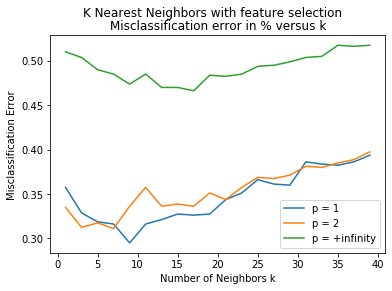

In [22]:
fs_cv_results = fs_grid_search_knn.cv_results_

# Calcul des erreurs de classification selon l'ordre p de la distance de minkowski
mse = defaultdict(list)
for i, estimator in enumerate(fs_cv_results["estimators"]):
    p_value = estimator.get_params()["p"]
    mse[p_value].append(1 - fs_cv_results["scores"][i])

# Affichage de l'erreur de classification en fonction de la valeur de k 
# et de l'ordre p de la distance de minkowski
plt.plot(n_neighbors, mse[1], label="p = 1")
plt.plot(n_neighbors, mse[2], label="p = 2")
plt.plot(n_neighbors, mse["+infty"], label="p = +infinity")
plt.suptitle("K Nearest Neighbors with feature selection")
plt.title("Misclassification error in % versus k")
plt.xlabel("Number of Neighbors k")
plt.ylabel("Misclassification Error")
plt.legend()
plt.savefig("Models/knn_fs_misclassification_error.png")
plt.show()
plt.close()

In [23]:
print("The best hyperparameters from Grid Search are:\n", fs_grid_search_knn.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:\n %.2f"%(fs_grid_search_knn.best_score_))

The best hyperparameters from Grid Search are:
 {'n_neighbors': 9, 'metric': <function minkowski at 0x000001D854A98CA8>, 'p': 1}

The mean accuracy of a model with these hyperparameters is:
 0.70


On sauvegarde le meilleur modèle des deux situations.

In [24]:
best_knn = grid_search_knn.best_estimator_
best_fs_knn = fs_grid_search_knn.best_estimator_

# 5. Comparaison des deux meilleurs modèles
Avec et sans sélection des caractéristiques

In [25]:
print("Base model parameters:\n", base_model.get_params())
print("\nBest model parameters without feature selection:\n", best_knn.get_params())
print("\nBest model parameters with feature selection:\n", best_fs_knn.get_params())

Base model parameters:
 {'n_neighbors': 1, 'metric': <function minkowski at 0x000001D854A98CA8>, 'p': 2}

Best model parameters without feature selection:
 {'n_neighbors': 7, 'metric': <function minkowski at 0x000001D854A98CA8>, 'p': 1}

Best model parameters with feature selection:
 {'n_neighbors': 9, 'metric': <function minkowski at 0x000001D854A98CA8>, 'p': 1}


On entraîne les deux modèles.

In [26]:
# Entrainement du meilleur modele sans selection des caractéristiques
best_knn.fit(data_train, label_train)

# Test de validation
start = time.time()
best_knn_predictions = best_knn.predict(data_test)
end = time.time()
print("Execution time for k nearest classifier training: %f sec"%(float(end) - float(start)))

best_knn.score_ = sc.accuracy_score(best_knn_predictions, label_test) * 100

Execution time for k nearest classifier training: 3.173723 sec


In [27]:
# Entrainement du meilleur modele avec selection des caracteristiques
best_fs_knn.fit(data_train, label_train)

# Test de validation
start = time.time()
best_fs_knn_predictions = best_fs_knn.predict(data_test)
end = time.time()
print("Execution time for k nearest classifier training: %f sec"%(float(end) - float(start)))

best_fs_knn.score_ = sc.accuracy_score(best_fs_knn_predictions, label_test) * 100

Execution time for k nearest classifier training: 3.424762 sec


### Matrices de confusion

In [28]:
d = {
    'genre': genre_list,
    'genre_code': labels
}
df_genre = pd.DataFrame(d).drop_duplicates().sort_values('genre_code')

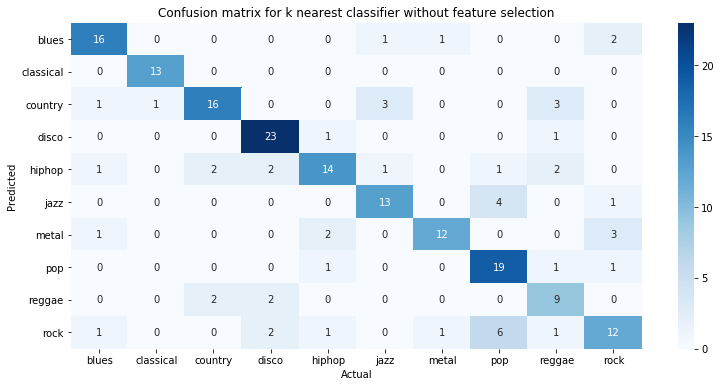

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(label_test, best_knn_predictions)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix,
            annot=True,
            xticklabels=df_genre['genre'].values,
            yticklabels=df_genre['genre'].values,
            cmap="Blues")
            
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix for k nearest classifier without feature selection')
plt.savefig('models/confusion_matrix_knn.png')
plt.show()
plt.close()

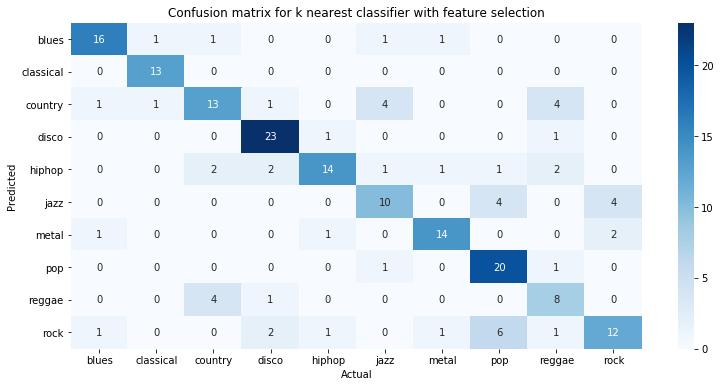

In [30]:
fs_conf_matrix = confusion_matrix(label_test, best_fs_knn_predictions)
plt.figure(figsize=(12.8,6))
sns.heatmap(fs_conf_matrix,
            annot=True,
            xticklabels=df_genre['genre'].values,
            yticklabels=df_genre['genre'].values,
            cmap="Blues")
            
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix for k nearest classifier with feature selection')
plt.savefig('models/confusion_matrix_knn_fs.png')
plt.show()
plt.close()

Voyons si le réglage des hyperparamètres a permis d'obtenir un meilleur modèle.

In [31]:
print("Base model score: {} %".format(base_model.score_))
print("Best model score without feature selection: {} %".format(best_knn.score_))
print("Best model score with feature selection: {} %".format(best_fs_knn.score_))

Base model score: 67.0 %
Best model score without feature selection: 73.5 %
Best model score with feature selection: 71.5 %


Sauvegardons le score du modèle pour pouvoir le comparer aux autres modèles.

In [32]:
d = {
    'Model': 'K Nearest Neighbors',
    'Test Set Accuracy': best_knn.score_
}

df_models_knn = pd.DataFrame(d, index=[0])

In [33]:
with open('models/best_knn.pickle', 'wb') as output:
    pickle.dump(best_knn, output)

with open('models/df_models_knn.pickle', 'wb') as output:
    pickle.dump(df_models_knn, output)